# Knee OA Classifier — Multi‑Model (ResNet18 • ResNet50 • InceptionV3)
*Generated on 2025-09-23 04:31:37*

**What this notebook does**
- Uses the same dataset/augmentation/sampler across models for a fair comparison.
- Trains **ResNet18**, **ResNet50**, and **InceptionV3** sequentially.
- Enforces **minimum 50 epochs** before early stopping can trigger.
- Saves best checkpoints per model, and produces:
  - Training curves (loss/accuracy)
  - Confusion matrices
  - ROC & PR curves
  - Classification reports
- Ends with a **summary comparison table** of all models.


In [1]:
import os, random, time, math, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image

from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, precision_recall_curve)

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import kagglehub

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# ===== Config =====
SEED = 42
BATCH_SIZE = 32
NUM_WORKERS = 0
NUM_EPOCHS = 100       # maximum
MIN_EPOCHS = 30       # force at least this many
PATIENCE = 5           # early stopping patience AFTER 50 epochs
LR = 3e-4
WEIGHT_DECAY = 1e-4
PRETRAINED = True

CLASSES = ['0','1','2','3','4']
N_CLASSES = len(CLASSES)

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)


Using device: cuda


In [2]:
# # ===== Download and index dataset =====
# path = kagglehub.dataset_download("shashwatwork/knee-osteoarthritis-dataset-with-severity")
# print("Dataset path:", path)
path = 'Data'
DATA_DIR = Path(path)
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR  = DATA_DIR / 'test'

def load_dataset_as_dataframe(subdir: str, max_images=None):
    root = TRAIN_DIR.parent / subdir
    rows = []
    for cls in CLASSES:
        cdir = root / cls
        if not cdir.exists(): 
            continue
        files = sorted([p for p in cdir.iterdir() if p.is_file() and p.suffix.lower() in {'.png', '.jpg', '.jpeg'}])
        if max_images:
            files = files[:max_images]
        for p in files:
            rows.append({'path': str(p), 'label': int(cls)})
    return pd.DataFrame(rows)

train_df = load_dataset_as_dataframe('train')
test_df  = load_dataset_as_dataframe('test')
print(train_df.shape, test_df.shape)

# stratified split
tr_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=SEED)
print(tr_df.shape, val_df.shape)


(5778, 2) (1656, 2)
(4622, 2) (1156, 2)


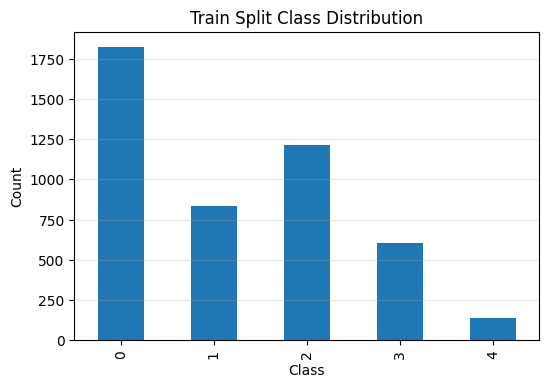

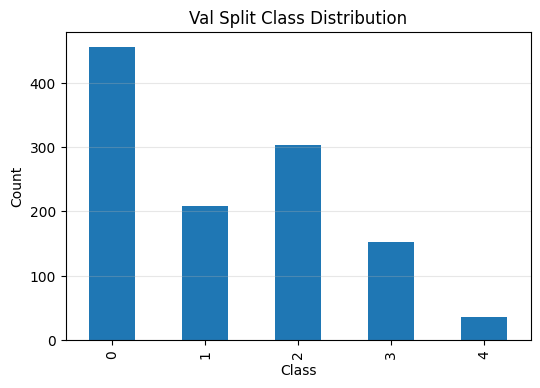

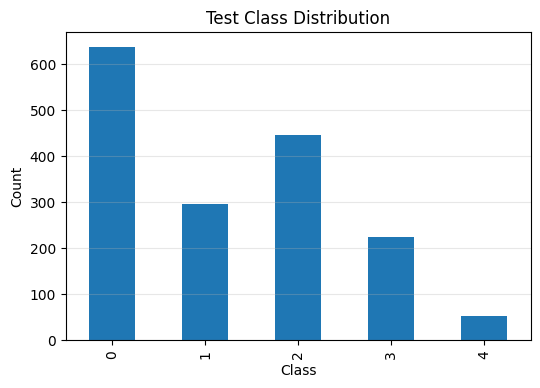

Class counts: {0: 1829, 1: 837, 2: 1213, 3: 605, 4: 138}
Class weights: [0.50541279 1.10442055 0.76207749 1.52793388 6.69855072]


In [3]:
# ===== Class distribution =====
def plot_class_distribution(df, title):
    counts = df['label'].value_counts().sort_index()
    plt.figure(figsize=(6,4))
    counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    return counts

train_counts = plot_class_distribution(tr_df, 'Train Split Class Distribution')
val_counts   = plot_class_distribution(val_df, 'Val Split Class Distribution')
test_counts  = plot_class_distribution(test_df, 'Test Class Distribution')

# imbalance weights + sampler
class_counts = tr_df['label'].value_counts().sort_index()
total = class_counts.sum()
class_weights = (total / (len(CLASSES) * class_counts)).to_numpy()
sample_weights = tr_df['label'].map({i: w for i, w in enumerate(class_weights)}).to_numpy()

print('Class counts:', class_counts.to_dict())
print('Class weights:', class_weights)


In [4]:
# ===== Transforms factory =====
def get_transforms(img_size):
    train_tfms = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.02),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    eval_tfms = transforms.Compose([
        transforms.Resize(int(img_size*1.15)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return train_tfms, eval_tfms


In [5]:
# ===== Dataset =====
class KneeDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['path']).convert('RGB')
        img = self.transform(img) if self.transform else img
        label = int(row['label'])
        return img, label


In [6]:
# ===== Model factory =====
def build_model(name, num_classes=N_CLASSES, pretrained=PRETRAINED, inception_aux_when_training=True):
    if name == 'resnet18':
        m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        in_feats = m.fc.in_features
        m.fc = nn.Linear(in_feats, num_classes)
        img_size = 224
        aux = False
    elif name == 'resnet50':
        m = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
        in_feats = m.fc.in_features
        m.fc = nn.Linear(in_feats, num_classes)
        img_size = 224
        aux = False
    elif name == 'inception_v3':
        # Inception needs 299x299 and supports aux logits
        m = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT if pretrained else None, aux_logits=inception_aux_when_training)
        in_feats = m.fc.in_features
        m.fc = nn.Linear(in_feats, num_classes)
        if getattr(m, 'AuxLogits', None) is not None:
            m.AuxLogits.fc = nn.Linear(m.AuxLogits.fc.in_features, num_classes)
        img_size = 299
        aux = True if inception_aux_when_training else False
    else:
        raise ValueError(f'Unknown model: {name}')
    return m, img_size, aux


In [7]:
# ===== Utilities =====
def accuracy_from_logits(logits, targets):
    preds = torch.argmax(logits, dim=1)
    return (preds == targets).float().mean().item()

@torch.no_grad()
def evaluate(model, loader, criterion, return_logits=True):
    model.eval()
    all_logits, all_targets = [], []
    running_loss = 0.0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        if isinstance(outputs, tuple):  # inception returns (logits, aux)
            logits = outputs[0]
        else:
            logits = outputs
        loss = criterion(logits, labels)
        running_loss += loss.item() * imgs.size(0)
        if return_logits:
            all_logits.append(logits.detach().cpu())
            all_targets.append(labels.detach().cpu())
    if return_logits and len(all_logits):
        all_logits = torch.cat(all_logits)
        all_targets = torch.cat(all_targets)
        acc = accuracy_from_logits(all_logits, all_targets)
        return running_loss / len(loader.dataset), acc, all_logits, all_targets
    else:
        return running_loss / len(loader.dataset), None, None, None

def train_one_epoch(model, loader, optimizer, scaler, criterion, use_inception_aux=False, aux_weight=0.4):
    model.train()
    running_loss, running_acc = 0.0, 0.0
    for imgs, labels in tqdm(loader, leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
            outputs = model(imgs)
            if use_inception_aux and isinstance(outputs, tuple):
                logits, aux_logits = outputs
                loss = criterion(logits, labels) + aux_weight * criterion(aux_logits, labels)
            else:
                logits = outputs
                loss = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * imgs.size(0)
        running_acc += accuracy_from_logits(logits.detach(), labels) * imgs.size(0)
    n = len(loader.dataset)
    return running_loss / n, running_acc / n


In [8]:
# ===== Plot helpers =====
def plot_curves(history, title_prefix):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(history['train_loss'], label='train_loss')
    ax.plot(history['val_loss'], label='val_loss')
    ax.set_title(f'{title_prefix} — Loss')
    ax.set_xlabel('Epoch'); ax.set_ylabel('Loss'); ax.grid(alpha=0.3); ax.legend()
    plt.show()

    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(history['train_acc'], label='train_acc')
    ax.plot(history['val_acc'], label='val_acc')
    ax.set_title(f'{title_prefix} — Accuracy')
    ax.set_xlabel('Epoch'); ax.set_ylabel('Accuracy'); ax.grid(alpha=0.3); ax.legend()
    plt.show()

def plot_confusion(y_true, logits, title, classes=CLASSES):
    import numpy as np
    cm = confusion_matrix(y_true, torch.argmax(logits,1).numpy(), labels=list(range(len(classes))))
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes, ylabel='True', xlabel='Pred')
    plt.title(title); plt.tight_layout(); plt.show()
    print(classification_report(y_true, torch.argmax(logits,1).numpy(), digits=4))

def plot_roc_pr(logits, targets, title_prefix=''):
    import numpy as np
    probs = torch.softmax(logits, dim=1).numpy()
    y_true = np.eye(len(CLASSES))[targets.numpy()]

    # ROC
    fig, ax = plt.subplots(figsize=(6,5))
    for i in range(len(CLASSES)):
        fpr, tpr, _ = roc_curve(y_true[:, i], probs[:, i])
        ax.plot(fpr, tpr, label=f'Class {i}')
    ax.plot([0,1],[0,1], '--')
    ax.set_title(f'{title_prefix} ROC Curves'); ax.set_xlabel('FPR'); ax.set_ylabel('TPR'); ax.grid(alpha=0.3); ax.legend()
    plt.show()

    # PR
    fig, ax = plt.subplots(figsize=(6,5))
    from sklearn.metrics import precision_recall_curve
    for i in range(len(CLASSES)):
        prec, rec, _ = precision_recall_curve(y_true[:, i], probs[:, i])
        ax.plot(rec, prec, label=f'Class {i}')
    ax.set_title(f'{title_prefix} Precision-Recall Curves'); ax.set_xlabel('Recall'); ax.set_ylabel('Precision'); ax.grid(alpha=0.3); ax.legend()
    plt.show()


In [9]:
# ===== Core: Train & Evaluate one model =====
def train_and_evaluate(model_name):
    # Build model & transforms
    model, img_size, use_aux = build_model(model_name)
    train_tfms, eval_tfms = get_transforms(img_size)

    # Datasets & loaders (same sampler/weights for fairness)
    train_ds = KneeDataset(tr_df, train_tfms)
    val_ds   = KneeDataset(val_df, eval_tfms)
    test_ds  = KneeDataset(test_df, eval_tfms)

    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    # Loss/opt/sched
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32, device=device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

    # Training
    best_val_acc = -1.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
    ckpt_path = f'best_{model_name}.pt'
    patience_used = 0

    for epoch in range(1, NUM_EPOCHS+1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler, criterion, use_inception_aux=use_aux)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
        scheduler.step(val_acc)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        print(f"[{model_name}] Epoch {epoch:02d} | "
              f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} | "
              f"lr={optimizer.param_groups[0]['lr']:.2e} | "
              f"{time.strftime('%Mm %Ss', time.gmtime(time.time()-t0))}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({'model_state_dict': model.state_dict(),
                        'config': {'classes': CLASSES, 'img_size': img_size}}, ckpt_path)
            patience_used = 0
        else:
            patience_used += 1

        if epoch >= MIN_EPOCHS and patience_used >= PATIENCE:
            print(f"[{model_name}] Early stopping at epoch {epoch}.")
            break

    # Reload best and full evaluation
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])

    val_loss, val_acc, val_logits, val_targets = evaluate(model, val_loader, criterion)
    test_loss, test_acc, test_logits, test_targets = evaluate(model, test_loader, criterion)

    # Plots
    plot_curves(history, title_prefix=model_name)
    plot_confusion(val_targets.numpy(), val_logits, f'{model_name} — Val Confusion Matrix')
    plot_confusion(test_targets.numpy(), test_logits, f'{model_name} — Test Confusion Matrix')
    plot_roc_pr(val_logits, val_targets, title_prefix=f'{model_name} Val')
    plot_roc_pr(test_logits, test_targets, title_prefix=f'{model_name} Test')

    # Save artifacts & return metrics
    torch.save(model.state_dict(), f'final_{model_name}_state_dict.pt')
    with open(f'label_map_{model_name}.json', 'w') as f:
        json.dump({'classes': CLASSES}, f, indent=2)

    return {
        'model': model_name,
        'val_acc': float(val_acc),
        'test_acc': float(test_acc),
        'val_loss': float(val_loss),
        'test_loss': float(test_loss)
    }



============================== resnet18 ==============================


[resnet18] Epoch 01 | train_loss=0.7005 train_acc=0.4498 | val_loss=0.9242 val_acc=0.4031 | lr=3.00e-04 | 01m 30s


[resnet18] Epoch 02 | train_loss=0.4806 train_acc=0.5612 | val_loss=0.9864 val_acc=0.3780 | lr=3.00e-04 | 01m 13s


[resnet18] Epoch 03 | train_loss=0.4228 train_acc=0.5792 | val_loss=1.0551 val_acc=0.3356 | lr=3.00e-04 | 01m 12s


Epoch 00004: reducing learning rate of group 0 to 1.5000e-04.
[resnet18] Epoch 04 | train_loss=0.3837 train_acc=0.6121 | val_loss=0.8928 val_acc=0.3945 | lr=1.50e-04 | 01m 12s


[resnet18] Epoch 05 | train_loss=0.3639 train_acc=0.6242 | val_loss=0.8651 val_acc=0.4559 | lr=1.50e-04 | 01m 11s


[resnet18] Epoch 06 | train_loss=0.3486 train_acc=0.6346 | val_loss=0.8703 val_acc=0.4308 | lr=1.50e-04 | 01m 11s


[resnet18] Epoch 07 | train_loss=0.3203 train_acc=0.6473 | val_loss=0.9746 val_acc=0.4135 | lr=1.50e-04 | 01m 11s


[resnet18] Epoch 08 | train_loss=0.3167 train_acc=0.6558 | val_loss=0.8142 val_acc=0.5121 | lr=1.50e-04 | 01m 12s


[resnet18] Epoch 09 | train_loss=0.3047 train_acc=0.6765 | val_loss=0.8582 val_acc=0.5623 | lr=1.50e-04 | 01m 12s


[resnet18] Epoch 10 | train_loss=0.2886 train_acc=0.6798 | val_loss=0.8600 val_acc=0.4481 | lr=1.50e-04 | 01m 12s


[resnet18] Epoch 11 | train_loss=0.2998 train_acc=0.6789 | val_loss=0.8401 val_acc=0.4983 | lr=1.50e-04 | 01m 11s


Epoch 00012: reducing learning rate of group 0 to 7.5000e-05.
[resnet18] Epoch 12 | train_loss=0.2982 train_acc=0.6822 | val_loss=0.8360 val_acc=0.5173 | lr=7.50e-05 | 01m 11s


[resnet18] Epoch 13 | train_loss=0.2635 train_acc=0.7125 | val_loss=0.7794 val_acc=0.6012 | lr=7.50e-05 | 01m 11s


[resnet18] Epoch 14 | train_loss=0.2360 train_acc=0.7231 | val_loss=0.8472 val_acc=0.5536 | lr=7.50e-05 | 01m 11s


[resnet18] Epoch 15 | train_loss=0.2346 train_acc=0.7384 | val_loss=0.8441 val_acc=0.5069 | lr=7.50e-05 | 01m 11s


Epoch 00016: reducing learning rate of group 0 to 3.7500e-05.
[resnet18] Epoch 16 | train_loss=0.2400 train_acc=0.7376 | val_loss=0.8615 val_acc=0.5363 | lr=3.75e-05 | 01m 11s


[resnet18] Epoch 17 | train_loss=0.2154 train_acc=0.7525 | val_loss=0.8334 val_acc=0.5908 | lr=3.75e-05 | 01m 11s


[resnet18] Epoch 18 | train_loss=0.1952 train_acc=0.7746 | val_loss=0.8426 val_acc=0.5952 | lr=3.75e-05 | 01m 11s


Epoch 00019: reducing learning rate of group 0 to 1.8750e-05.
[resnet18] Epoch 19 | train_loss=0.2014 train_acc=0.7709 | val_loss=0.8246 val_acc=0.5995 | lr=1.87e-05 | 01m 11s


[resnet18] Epoch 20 | train_loss=0.1918 train_acc=0.7919 | val_loss=0.8442 val_acc=0.5943 | lr=1.87e-05 | 01m 11s


[resnet18] Epoch 21 | train_loss=0.1833 train_acc=0.7893 | val_loss=0.8984 val_acc=0.5649 | lr=1.87e-05 | 01m 12s


Epoch 00022: reducing learning rate of group 0 to 9.3750e-06.
[resnet18] Epoch 22 | train_loss=0.1980 train_acc=0.7847 | val_loss=0.8945 val_acc=0.5796 | lr=9.37e-06 | 01m 11s


[resnet18] Epoch 23 | train_loss=0.1734 train_acc=0.8020 | val_loss=0.8617 val_acc=0.5900 | lr=9.37e-06 | 01m 11s


[resnet18] Epoch 24 | train_loss=0.1805 train_acc=0.7979 | val_loss=0.8843 val_acc=0.5891 | lr=9.37e-06 | 01m 11s


[resnet18] Epoch 25 | train_loss=0.1716 train_acc=0.8064 | val_loss=0.8829 val_acc=0.6064 | lr=9.37e-06 | 01m 11s


[resnet18] Epoch 26 | train_loss=0.1726 train_acc=0.7958 | val_loss=0.8752 val_acc=0.6176 | lr=9.37e-06 | 01m 11s


[resnet18] Epoch 27 | train_loss=0.1801 train_acc=0.7990 | val_loss=0.8870 val_acc=0.5761 | lr=9.37e-06 | 01m 11s


[resnet18] Epoch 28 | train_loss=0.1701 train_acc=0.8096 | val_loss=0.9034 val_acc=0.5796 | lr=9.37e-06 | 01m 11s


Epoch 00029: reducing learning rate of group 0 to 4.6875e-06.
[resnet18] Epoch 29 | train_loss=0.1717 train_acc=0.8129 | val_loss=0.8986 val_acc=0.5848 | lr=4.69e-06 | 01m 11s


[resnet18] Epoch 30 | train_loss=0.1620 train_acc=0.8174 | val_loss=0.9031 val_acc=0.5856 | lr=4.69e-06 | 01m 11s


[resnet18] Epoch 31 | train_loss=0.1587 train_acc=0.8267 | val_loss=0.9121 val_acc=0.5900 | lr=4.69e-06 | 01m 12s
[resnet18] Early stopping at epoch 31.


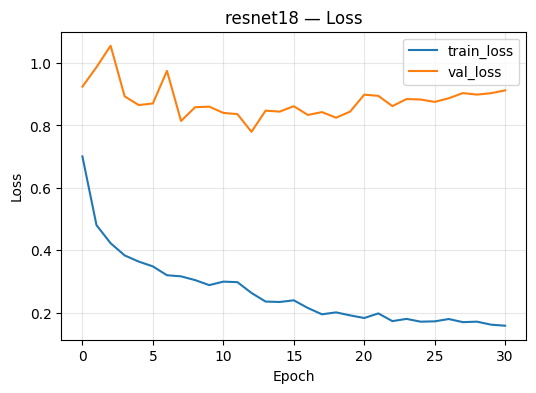

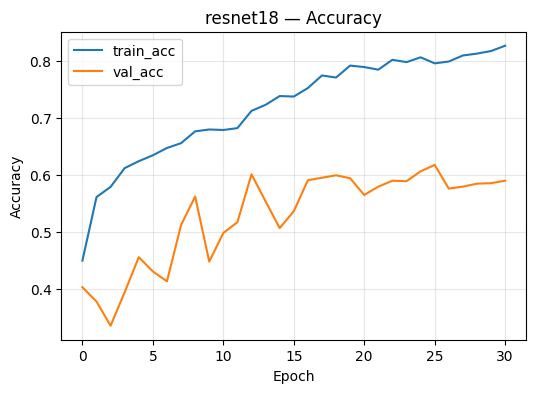

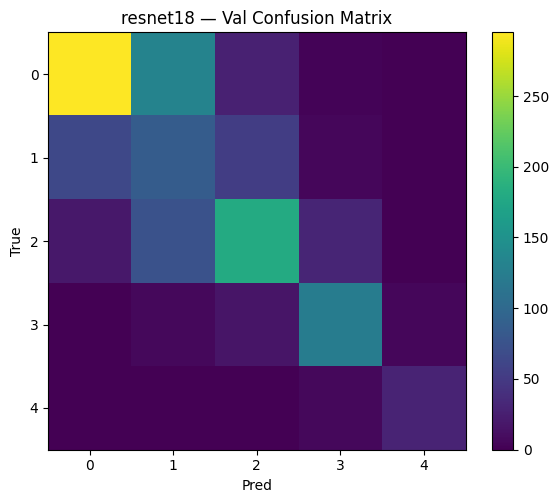

              precision    recall  f1-score   support

           0     0.7804    0.6455    0.7066       457
           1     0.2886    0.4115    0.3393       209
           2     0.6475    0.5941    0.6196       303
           3     0.7381    0.8158    0.7750       152
           4     0.8529    0.8286    0.8406        35

    accuracy                         0.6176      1156
   macro avg     0.6615    0.6591    0.6562      1156
weighted avg     0.6533    0.6176    0.6304      1156



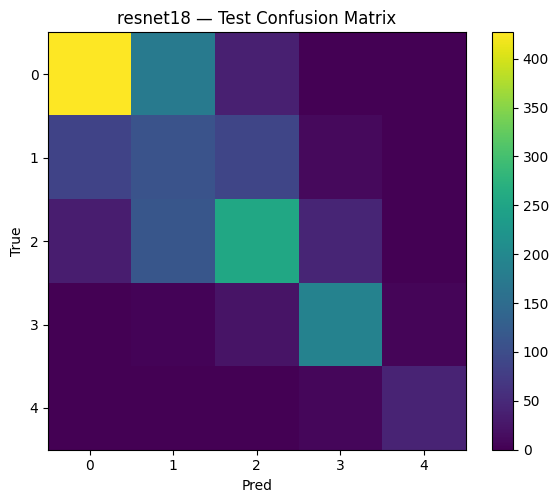

              precision    recall  f1-score   support

           0     0.7806    0.6682    0.7201       639
           1     0.2730    0.3716    0.3147       296
           2     0.6303    0.5682    0.5976       447
           3     0.7480    0.8520    0.7966       223
           4     0.8776    0.8431    0.8600        51

    accuracy                         0.6184      1656
   macro avg     0.6619    0.6606    0.6578      1656
weighted avg     0.6479    0.6184    0.6292      1656



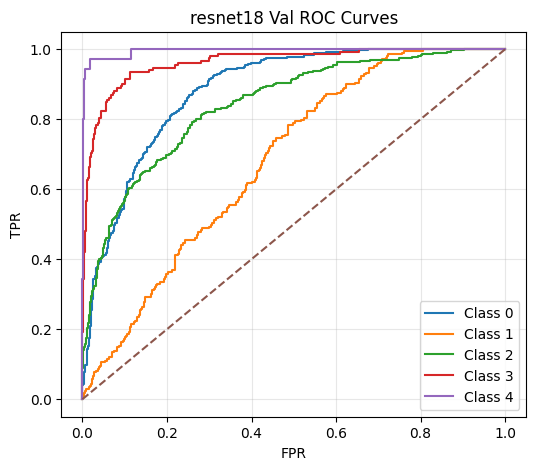

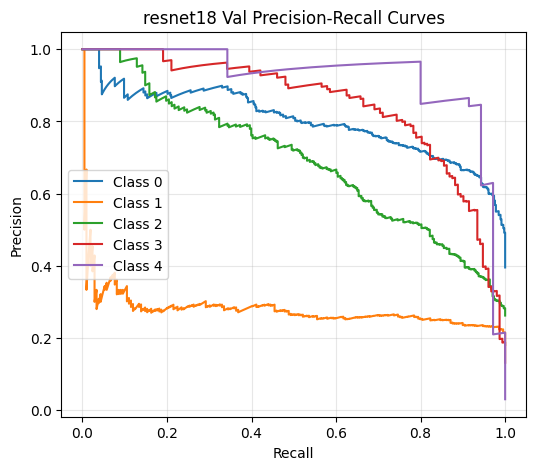

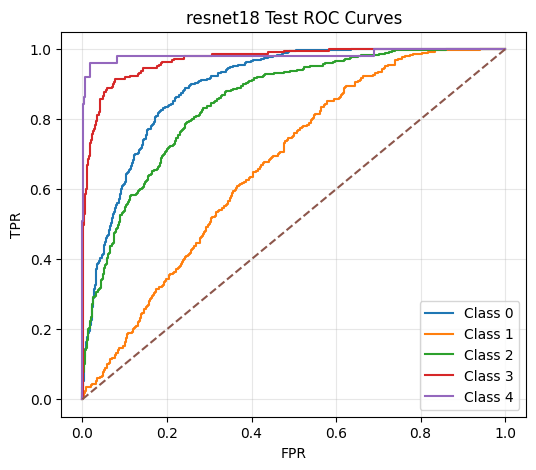

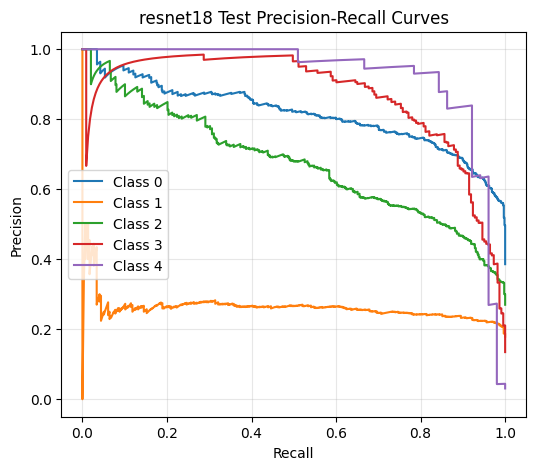


============================== resnet50 ==============================


[resnet50] Epoch 01 | train_loss=0.7318 train_acc=0.4087 | val_loss=1.0237 val_acc=0.3780 | lr=3.00e-04 | 03m 15s


[resnet50] Epoch 02 | train_loss=0.4776 train_acc=0.5630 | val_loss=0.9420 val_acc=0.4472 | lr=3.00e-04 | 03m 39s


[resnet50] Epoch 03 | train_loss=0.4071 train_acc=0.5978 | val_loss=0.8919 val_acc=0.4706 | lr=3.00e-04 | 03m 41s


[resnet50] Epoch 04 | train_loss=0.3778 train_acc=0.6244 | val_loss=0.8572 val_acc=0.4057 | lr=3.00e-04 | 03m 39s


[resnet50] Epoch 05 | train_loss=0.3594 train_acc=0.6398 | val_loss=0.8269 val_acc=0.5294 | lr=3.00e-04 | 03m 39s


[resnet50] Epoch 06 | train_loss=0.3249 train_acc=0.6540 | val_loss=0.9082 val_acc=0.4645 | lr=3.00e-04 | 03m 40s


[resnet50] Epoch 07 | train_loss=0.3350 train_acc=0.6659 | val_loss=0.8758 val_acc=0.4507 | lr=3.00e-04 | 03m 42s


[resnet50] Epoch 08 | train_loss=0.2939 train_acc=0.6815 | val_loss=0.7777 val_acc=0.5606 | lr=3.00e-04 | 03m 44s


[resnet50] Epoch 09 | train_loss=0.2953 train_acc=0.6852 | val_loss=0.8254 val_acc=0.4706 | lr=3.00e-04 | 03m 46s


[resnet50] Epoch 10 | train_loss=0.2845 train_acc=0.6928 | val_loss=0.7823 val_acc=0.5960 | lr=3.00e-04 | 03m 46s


[resnet50] Epoch 11 | train_loss=0.2933 train_acc=0.6949 | val_loss=0.7602 val_acc=0.5787 | lr=3.00e-04 | 03m 46s


[resnet50] Epoch 12 | train_loss=0.2735 train_acc=0.6993 | val_loss=0.7524 val_acc=0.5856 | lr=3.00e-04 | 03m 46s


Epoch 00013: reducing learning rate of group 0 to 1.5000e-04.
[resnet50] Epoch 13 | train_loss=0.2679 train_acc=0.7064 | val_loss=0.9891 val_acc=0.4654 | lr=1.50e-04 | 03m 46s


[resnet50] Epoch 14 | train_loss=0.2340 train_acc=0.7412 | val_loss=0.8139 val_acc=0.5450 | lr=1.50e-04 | 03m 45s


[resnet50] Epoch 15 | train_loss=0.2188 train_acc=0.7471 | val_loss=0.7997 val_acc=0.5433 | lr=1.50e-04 | 03m 46s


Epoch 00016: reducing learning rate of group 0 to 7.5000e-05.
[resnet50] Epoch 16 | train_loss=0.2247 train_acc=0.7525 | val_loss=0.9489 val_acc=0.5164 | lr=7.50e-05 | 03m 46s


[resnet50] Epoch 17 | train_loss=0.1979 train_acc=0.7728 | val_loss=0.7724 val_acc=0.6090 | lr=7.50e-05 | 03m 45s


[resnet50] Epoch 18 | train_loss=0.1884 train_acc=0.7759 | val_loss=0.7864 val_acc=0.5952 | lr=7.50e-05 | 03m 41s


[resnet50] Epoch 19 | train_loss=0.1839 train_acc=0.8016 | val_loss=0.8116 val_acc=0.5744 | lr=7.50e-05 | 04m 36s


Epoch 00020: reducing learning rate of group 0 to 3.7500e-05.
[resnet50] Epoch 20 | train_loss=0.1790 train_acc=0.8005 | val_loss=0.8183 val_acc=0.5917 | lr=3.75e-05 | 04m 44s


[resnet50] Epoch 21 | train_loss=0.1645 train_acc=0.8090 | val_loss=0.8164 val_acc=0.6038 | lr=3.75e-05 | 04m 35s


[resnet50] Epoch 22 | train_loss=0.1565 train_acc=0.8250 | val_loss=0.8355 val_acc=0.6142 | lr=3.75e-05 | 04m 36s


[resnet50] Epoch 23 | train_loss=0.1553 train_acc=0.8258 | val_loss=0.8660 val_acc=0.5882 | lr=3.75e-05 | 04m 42s


[resnet50] Epoch 24 | train_loss=0.1494 train_acc=0.8414 | val_loss=0.8855 val_acc=0.5848 | lr=3.75e-05 | 04m 44s


[resnet50] Epoch 25 | train_loss=0.1527 train_acc=0.8265 | val_loss=0.8654 val_acc=0.6332 | lr=3.75e-05 | 04m 44s


[resnet50] Epoch 26 | train_loss=0.1436 train_acc=0.8473 | val_loss=0.9020 val_acc=0.6073 | lr=3.75e-05 | 04m 41s


[resnet50] Epoch 27 | train_loss=0.1472 train_acc=0.8436 | val_loss=0.8841 val_acc=0.6220 | lr=3.75e-05 | 04m 36s


Epoch 00028: reducing learning rate of group 0 to 1.8750e-05.
[resnet50] Epoch 28 | train_loss=0.1367 train_acc=0.8453 | val_loss=0.8871 val_acc=0.6185 | lr=1.87e-05 | 04m 34s


[resnet50] Epoch 29 | train_loss=0.1208 train_acc=0.8659 | val_loss=0.8927 val_acc=0.6133 | lr=1.87e-05 | 04m 35s


[resnet50] Epoch 30 | train_loss=0.1234 train_acc=0.8687 | val_loss=0.9286 val_acc=0.6133 | lr=1.87e-05 | 04m 36s
[resnet50] Early stopping at epoch 30.


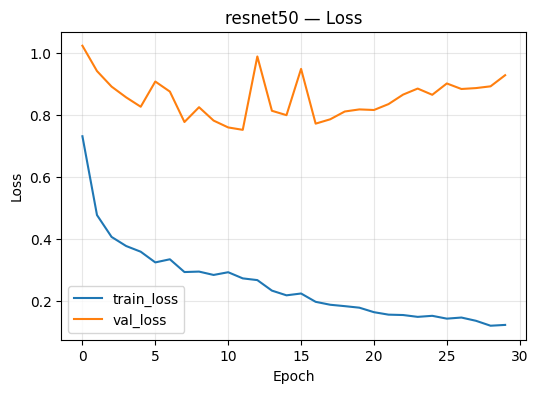

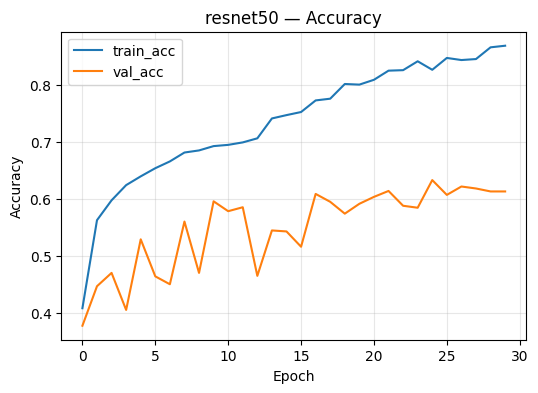

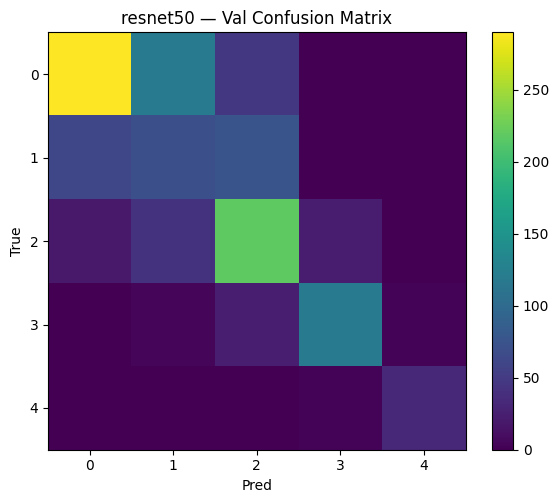

              precision    recall  f1-score   support

           0     0.7796    0.6346    0.6996       457
           1     0.2996    0.3397    0.3184       209
           2     0.5989    0.7195    0.6537       303
           3     0.8176    0.7961    0.8067       152
           4     0.9143    0.9143    0.9143        35

    accuracy                         0.6332      1156
   macro avg     0.6820    0.6808    0.6785      1156
weighted avg     0.6545    0.6332    0.6392      1156



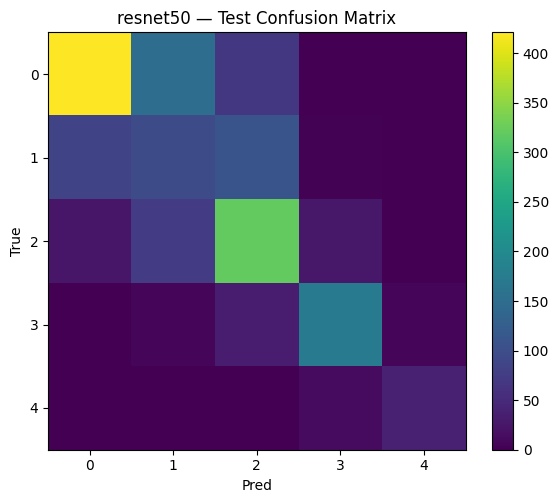

              precision    recall  f1-score   support

           0     0.7899    0.6588    0.7184       639
           1     0.2979    0.3311    0.3136       296
           2     0.6026    0.7159    0.6544       447
           3     0.8065    0.7848    0.7955       223
           4     0.8478    0.7647    0.8041        51

    accuracy                         0.6359      1656
   macro avg     0.6689    0.6511    0.6572      1656
weighted avg     0.6554    0.6359    0.6418      1656



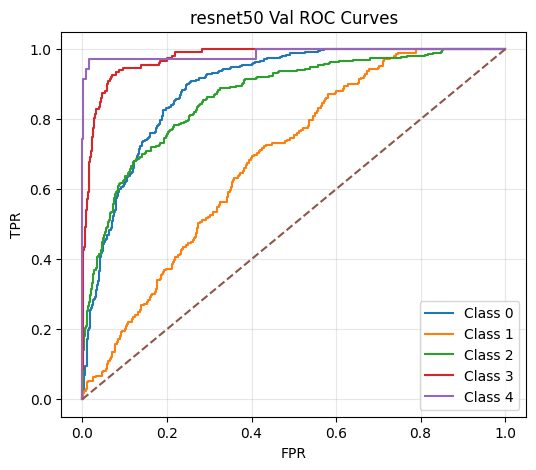

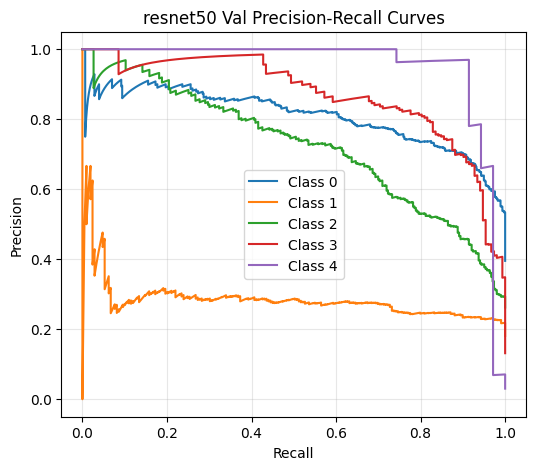

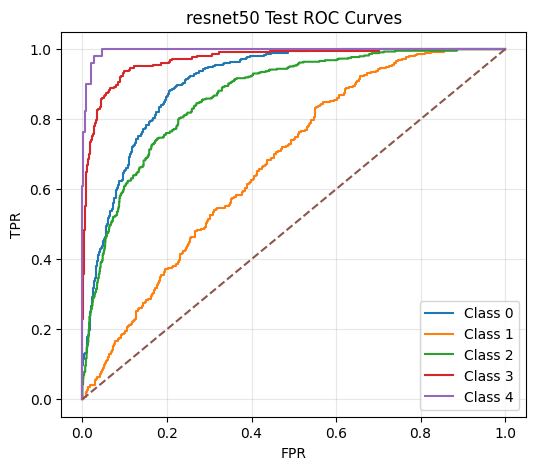

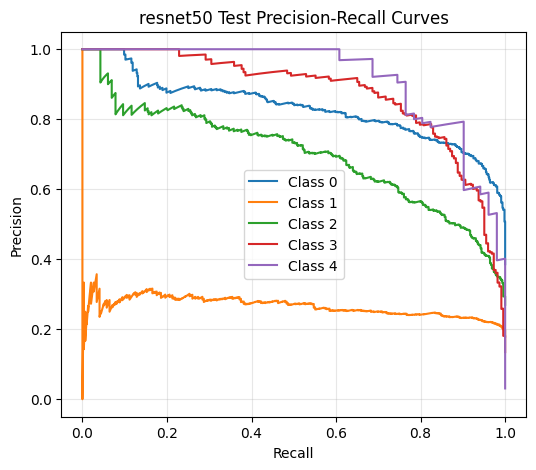


============================== inception_v3 ==============================


[inception_v3] Epoch 01 | train_loss=0.9630 train_acc=0.4580 | val_loss=0.9742 val_acc=0.3590 | lr=3.00e-04 | 22m 54s


[inception_v3] Epoch 02 | train_loss=0.6592 train_acc=0.5731 | val_loss=0.9847 val_acc=0.4377 | lr=3.00e-04 | 22m 49s


[inception_v3] Epoch 03 | train_loss=0.5701 train_acc=0.6023 | val_loss=0.8932 val_acc=0.4109 | lr=3.00e-04 | 22m 48s


[inception_v3] Epoch 04 | train_loss=0.5444 train_acc=0.6179 | val_loss=0.9156 val_acc=0.3434 | lr=3.00e-04 | 22m 28s


[inception_v3] Epoch 05 | train_loss=0.4694 train_acc=0.6491 | val_loss=0.8090 val_acc=0.4983 | lr=3.00e-04 | 22m 40s


[inception_v3] Epoch 06 | train_loss=0.4716 train_acc=0.6640 | val_loss=0.9981 val_acc=0.3824 | lr=3.00e-04 | 26m 45s


[inception_v3] Epoch 07 | train_loss=0.4908 train_acc=0.6402 | val_loss=0.8319 val_acc=0.4888 | lr=3.00e-04 | 27m 36s


[inception_v3] Epoch 08 | train_loss=0.4545 train_acc=0.6664 | val_loss=0.7845 val_acc=0.5147 | lr=3.00e-04 | 25m 33s


[inception_v3] Epoch 09 | train_loss=0.4269 train_acc=0.6807 | val_loss=0.9538 val_acc=0.4196 | lr=3.00e-04 | 25m 26s


[inception_v3] Epoch 10 | train_loss=0.4184 train_acc=0.6934 | val_loss=0.8938 val_acc=0.4619 | lr=3.00e-04 | 24m 53s


[inception_v3] Epoch 11 | train_loss=0.3868 train_acc=0.7148 | val_loss=0.8383 val_acc=0.5709 | lr=3.00e-04 | 24m 13s


[inception_v3] Epoch 12 | train_loss=0.3932 train_acc=0.7060 | val_loss=0.7383 val_acc=0.5908 | lr=3.00e-04 | 24m 10s


[inception_v3] Epoch 13 | train_loss=0.3489 train_acc=0.7187 | val_loss=1.0858 val_acc=0.4351 | lr=3.00e-04 | 27m 15s


[inception_v3] Epoch 14 | train_loss=0.3645 train_acc=0.7218 | val_loss=0.8751 val_acc=0.4559 | lr=3.00e-04 | 24m 06s


Epoch 00015: reducing learning rate of group 0 to 1.5000e-04.
[inception_v3] Epoch 15 | train_loss=0.3696 train_acc=0.7213 | val_loss=0.8558 val_acc=0.5484 | lr=1.50e-04 | 25m 31s


[inception_v3] Epoch 16 | train_loss=0.3327 train_acc=0.7421 | val_loss=0.8125 val_acc=0.5389 | lr=1.50e-04 | 24m 12s


[inception_v3] Epoch 17 | train_loss=0.2814 train_acc=0.7696 | val_loss=0.8281 val_acc=0.6081 | lr=1.50e-04 | 24m 13s


[inception_v3] Epoch 18 | train_loss=0.2755 train_acc=0.7756 | val_loss=0.8691 val_acc=0.4905 | lr=1.50e-04 | 26m 50s


[inception_v3] Epoch 19 | train_loss=0.2554 train_acc=0.7910 | val_loss=0.9116 val_acc=0.4991 | lr=1.50e-04 | 24m 14s


Epoch 00020: reducing learning rate of group 0 to 7.5000e-05.
[inception_v3] Epoch 20 | train_loss=0.2434 train_acc=0.8018 | val_loss=0.9110 val_acc=0.5796 | lr=7.50e-05 | 25m 35s


[inception_v3] Epoch 21 | train_loss=0.2193 train_acc=0.8284 | val_loss=0.8922 val_acc=0.5761 | lr=7.50e-05 | 24m 09s


[inception_v3] Epoch 22 | train_loss=0.2094 train_acc=0.8395 | val_loss=0.9513 val_acc=0.5597 | lr=7.50e-05 | 24m 27s


Epoch 00023: reducing learning rate of group 0 to 3.7500e-05.
[inception_v3] Epoch 23 | train_loss=0.1939 train_acc=0.8507 | val_loss=0.9792 val_acc=0.5666 | lr=3.75e-05 | 26m 46s


[inception_v3] Epoch 24 | train_loss=0.1745 train_acc=0.8540 | val_loss=0.9111 val_acc=0.5934 | lr=3.75e-05 | 24m 09s


[inception_v3] Epoch 25 | train_loss=0.1676 train_acc=0.8693 | val_loss=0.9378 val_acc=0.5882 | lr=3.75e-05 | 24m 50s


Epoch 00026: reducing learning rate of group 0 to 1.8750e-05.
[inception_v3] Epoch 26 | train_loss=0.1623 train_acc=0.8702 | val_loss=0.9136 val_acc=0.6003 | lr=1.87e-05 | 24m 11s


[inception_v3] Epoch 27 | train_loss=0.1502 train_acc=0.8892 | val_loss=0.9389 val_acc=0.6159 | lr=1.87e-05 | 24m 30s


[inception_v3] Epoch 28 | train_loss=0.1371 train_acc=0.8890 | val_loss=0.9597 val_acc=0.6237 | lr=1.87e-05 | 26m 45s


[inception_v3] Epoch 29 | train_loss=0.1267 train_acc=0.9016 | val_loss=0.9968 val_acc=0.6185 | lr=1.87e-05 | 24m 10s


[inception_v3] Epoch 30 | train_loss=0.1259 train_acc=0.8992 | val_loss=1.0786 val_acc=0.6047 | lr=1.87e-05 | 25m 39s


Epoch 00031: reducing learning rate of group 0 to 9.3750e-06.
[inception_v3] Epoch 31 | train_loss=0.1251 train_acc=0.9065 | val_loss=1.0474 val_acc=0.6168 | lr=9.37e-06 | 24m 11s


[inception_v3] Epoch 32 | train_loss=0.1133 train_acc=0.9065 | val_loss=1.0502 val_acc=0.6332 | lr=9.37e-06 | 24m 29s


[inception_v3] Epoch 33 | train_loss=0.1124 train_acc=0.9156 | val_loss=1.0576 val_acc=0.6246 | lr=9.37e-06 | 26m 24s


[inception_v3] Epoch 34 | train_loss=0.1213 train_acc=0.9083 | val_loss=1.1118 val_acc=0.6315 | lr=9.37e-06 | 24m 21s


Epoch 00035: reducing learning rate of group 0 to 4.6875e-06.
[inception_v3] Epoch 35 | train_loss=0.1064 train_acc=0.9225 | val_loss=1.0714 val_acc=0.6176 | lr=4.69e-06 | 25m 18s


[inception_v3] Epoch 36 | train_loss=0.1081 train_acc=0.9219 | val_loss=1.1159 val_acc=0.6133 | lr=4.69e-06 | 24m 16s


[inception_v3] Epoch 37 | train_loss=0.1012 train_acc=0.9225 | val_loss=1.0891 val_acc=0.6151 | lr=4.69e-06 | 25m 50s
[inception_v3] Early stopping at epoch 37.


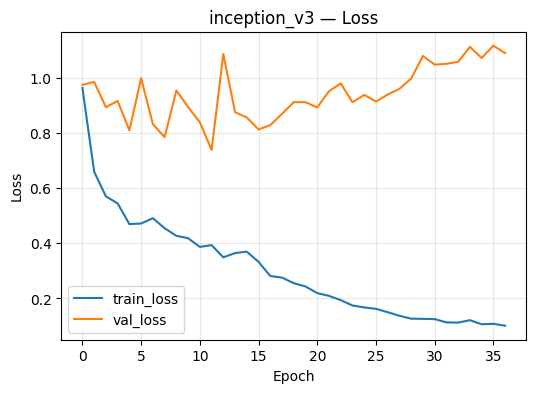

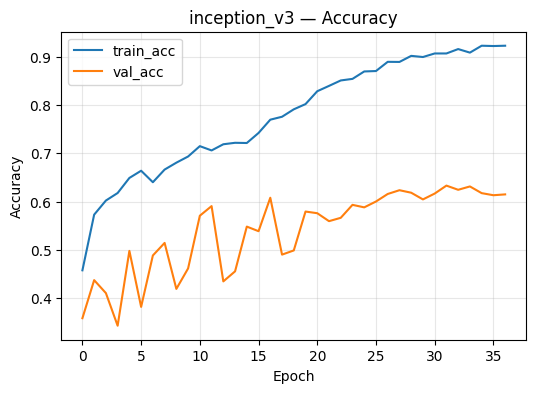

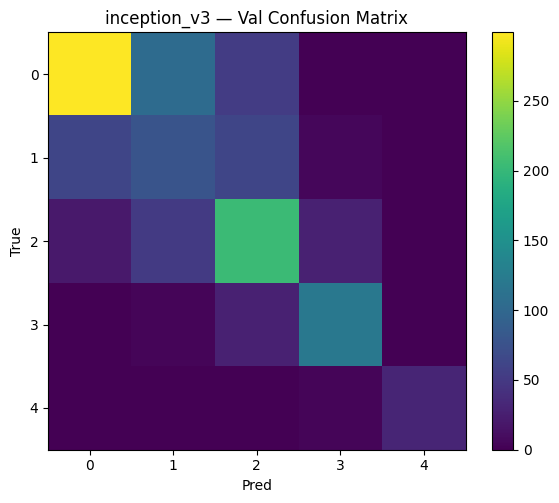

              precision    recall  f1-score   support

           0     0.7827    0.6543    0.7128       457
           1     0.3291    0.3732    0.3498       209
           2     0.5879    0.6733    0.6277       303
           3     0.7595    0.7895    0.7742       152
           4     0.9688    0.8857    0.9254        35

    accuracy                         0.6332      1156
   macro avg     0.6856    0.6752    0.6780      1156
weighted avg     0.6522    0.6332    0.6393      1156



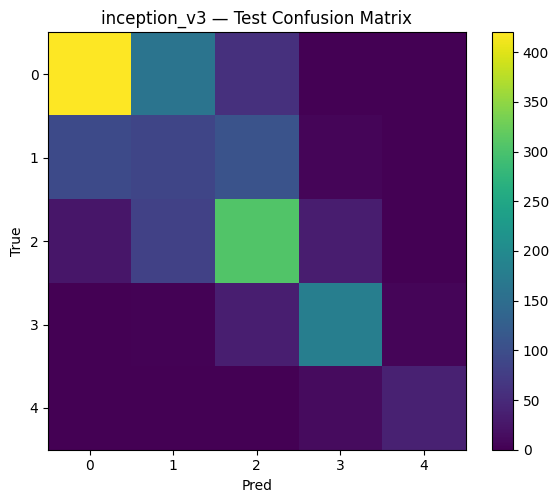

              precision    recall  f1-score   support

           0     0.7749    0.6573    0.7113       639
           1     0.2651    0.2973    0.2803       296
           2     0.6047    0.6846    0.6422       447
           3     0.7749    0.8027    0.7885       223
           4     0.8667    0.7647    0.8125        51

    accuracy                         0.6232      1656
   macro avg     0.6573    0.6413    0.6469      1656
weighted avg     0.6407    0.6232    0.6291      1656



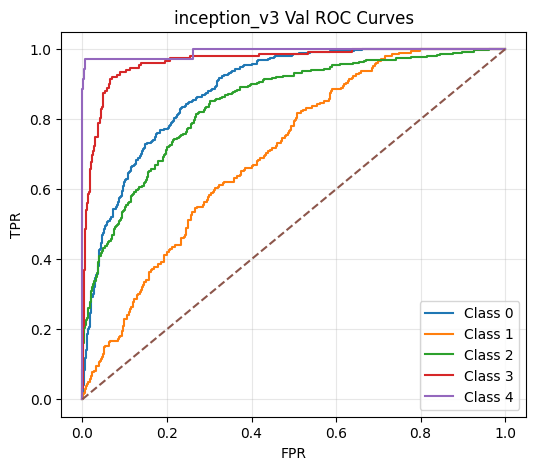

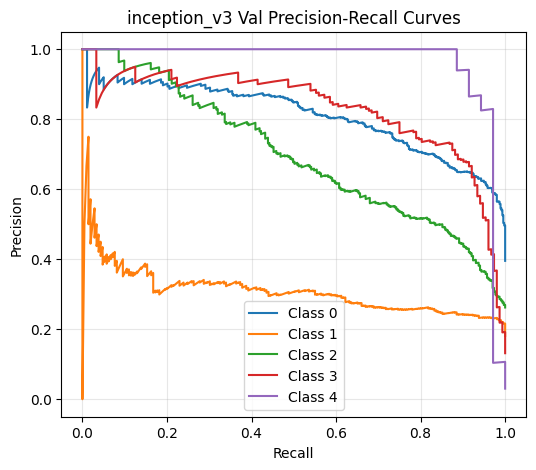

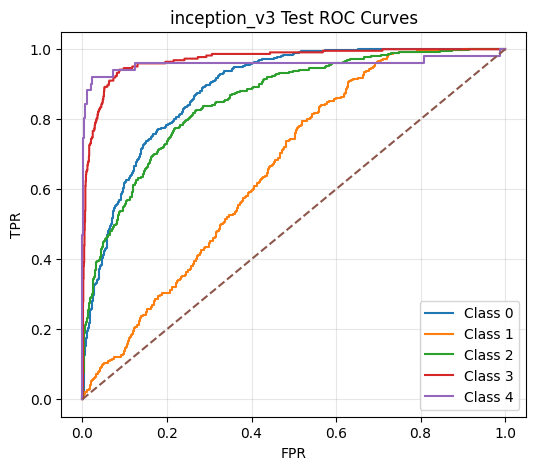

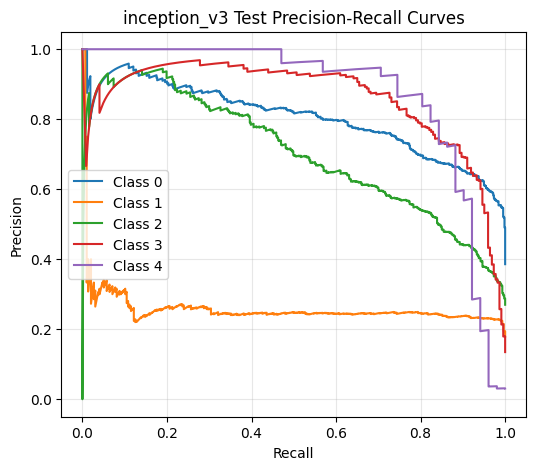

,model,val_acc,test_acc,val_loss,test_loss
1,resnet50,0.633218,0.635870,0.865436,0.934456
2,inception_v3,0.633218,0.623188,1.050225,1.160153
0,resnet18,0.617647,0.618357,0.875199,0.932749


Saved model_comparison.csv


In [10]:
# ===== Run: ResNet18, ResNet50, InceptionV3 =====
results = []
for mname in ['resnet18', 'resnet50', 'inception_v3']:
    print('\n' + '='*30, mname, '='*30)
    metrics = train_and_evaluate(mname)
    results.append(metrics)

df_results = pd.DataFrame(results).sort_values('val_acc', ascending=False)
display(df_results)
df_results.to_csv('model_comparison.csv', index=False)
print('Saved model_comparison.csv')


## Optional: Grad-CAM (after training)
Install and visualize for any of the trained models.

```python
!python -m pip install --upgrade pip
!pip install grad-cam

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Load a model checkpoint e.g. resnet50
model_chkpt = torch.load('best_resnet50.pt', map_location=device)
model, img_size, _ = build_model('resnet50', pretrained=False)
model.load_state_dict(model_chkpt['model_state_dict'])
model = model.to(device).eval()

_, _, _, _ = evaluate(model, DataLoader(KneeDataset(val_df, get_transforms(img_size)[1]), batch_size=32), nn.CrossEntropyLoss())

target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=(device.type=='cuda'))
val_loader = DataLoader(KneeDataset(val_df, get_transforms(img_size)[1]), batch_size=1, shuffle=True)
imgs, labels = next(iter(val_loader))
mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
rgb = imgs*std + mean
rgb = torch.clamp(rgb,0,1)
grayscale_cam = cam(input_tensor=imgs.to(device), targets=[ClassifierOutputTarget(int(labels[0]))])[0]
viz = show_cam_on_image(rgb[0].permute(1,2,0).numpy(), grayscale_cam, use_rgb=True)
plt.imshow(viz); plt.axis('off')
```

(-0.5, 223.5, 223.5, -0.5)

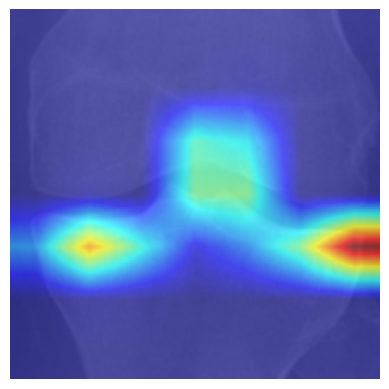

In [16]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Load a model checkpoint e.g. resnet50
model_chkpt = torch.load('best_resnet50.pt', map_location=device)
model, img_size, _ = build_model('resnet50', pretrained=False)
model.load_state_dict(model_chkpt['model_state_dict'])
model = model.to(device).eval()

_, _, _, _ = evaluate(model, DataLoader(KneeDataset(val_df, get_transforms(img_size)[1]), batch_size=32), nn.CrossEntropyLoss())

target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)
val_loader = DataLoader(KneeDataset(val_df, get_transforms(img_size)[1]), batch_size=1, shuffle=True)
imgs, labels = next(iter(val_loader))
mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
rgb = imgs*std + mean
rgb = torch.clamp(rgb,0,1)
grayscale_cam = cam(input_tensor=imgs.to(device), targets=[ClassifierOutputTarget(int(labels[0]))])[0]
viz = show_cam_on_image(rgb[0].permute(1,2,0).numpy(), grayscale_cam, use_rgb=True)
plt.imshow(viz); plt.axis('off')